In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
from scipy import stats
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from numpy import percentile


from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, SGDRegressor, LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, RobustScaler, QuantileTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
import math

sns.set()

    Filter out data using SQL propertylandusetypeid = 261 and transactiondate 2017

In [2]:
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   bedroomcnt                    52441 non-null  float64
 2   bathroomcnt                   52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   poolcnt                       11096 non-null  float64
 5   pooltypeid2                   1071 non-null   float64
 6   hashottuborspa                1515 non-null   float64
 7   fireplacecnt                  7243 non-null   float64
 8   garagecarcnt                  18015 non-null  float64
 9   numberofstories               14561 non-null  float64
 10  airconditioningtypeid         13638 non-null  float64
 11  heatingorsystemtypeid         33935 non-null  float64
 12  yearbuilt                     52325 non-null  float64
 13  l

    Verify there are no duplicates in df. Yay no duplicates

In [4]:
df.duplicated().sum()

0

    How many NaN values in df

In [5]:
df_prep = df.copy(deep=True)
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       82
poolcnt                         41345
pooltypeid2                     51370
hashottuborspa                  50926
fireplacecnt                    45198
garagecarcnt                    34426
numberofstories                 37880
airconditioningtypeid           38803
heatingorsystemtypeid           18506
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    Determine the number of unique values in each column

In [6]:
df_prep.garagecarcnt.value_counts()

2.0     14802
1.0      2202
3.0       621
4.0       254
0.0        65
5.0        45
6.0        13
7.0         3
10.0        3
8.0         2
9.0         2
11.0        1
13.0        1
14.0        1
Name: garagecarcnt, dtype: int64

In [7]:
df_prep.bathroomcnt.value_counts()

2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64

In [8]:
df_prep.bedroomcnt.value_counts()

3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64

In [9]:
df_prep.poolcnt.value_counts()

1.0    11096
Name: poolcnt, dtype: int64

In [10]:
df_prep.pooltypeid2.value_counts()

1.0    1071
Name: pooltypeid2, dtype: int64

In [11]:
df_prep.hashottuborspa.value_counts()

1.0    1515
Name: hashottuborspa, dtype: int64

    Since there is not a reasonable way of determining the unique number of rooms and bathroom I will replace zero values in bath & bed with NaN.

In [12]:
bed_bath_0_columns = ['bedroomcnt', 'bathroomcnt']
df_prep[bed_bath_0_columns] = df_prep[bed_bath_0_columns].replace(0, np.NaN)
df_prep = df_prep.reset_index(drop=True)

In [13]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                         41345
pooltypeid2                     51370
hashottuborspa                  50926
fireplacecnt                    45198
garagecarcnt                    34426
numberofstories                 37880
airconditioningtypeid           38803
heatingorsystemtypeid           18506
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    Since all fire/pool/gareage that NaN are 0 we will replace NaN values with 0 for pool, fire, and garage

In [14]:
fire_garge_pool_0_columns = ['poolcnt','pooltypeid2','hashottuborspa', 'fireplacecnt','garagecarcnt']
df_prep[fire_garge_pool_0_columns] = df_prep[fire_garge_pool_0_columns].replace(np.NaN, 0)
df_prep = df_prep.reset_index(drop=True)


In [15]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                             0
pooltypeid2                         0
hashottuborspa                      0
fireplacecnt                        0
garagecarcnt                        0
numberofstories                 37880
airconditioningtypeid           38803
heatingorsystemtypeid           18506
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    Replace airconditioningtypeid value 5 to 0 and value 13 to 1 

In [16]:
df_prep.airconditioningtypeid.replace(5, 0, inplace=True) # No AC   
df_prep.airconditioningtypeid.replace(13, 1, inplace=True) # Central AC

In [17]:
df_prep.airconditioningtypeid.value_counts()

1.0     13463
0.0       159
11.0       16
Name: airconditioningtypeid, dtype: int64

In [18]:
df_prep.heatingorsystemtypeid.value_counts()

2.0     20736
7.0     12565
6.0       517
20.0       85
13.0       16
1.0         7
18.0        6
10.0        2
24.0        1
Name: heatingorsystemtypeid, dtype: int64

    replace heatingorsystemtypeid value 13 = no heating with 0 and replace NaN with most frequent value

In [19]:
df_prep.heatingorsystemtypeid.replace(13, 0, inplace=True) # no heat
df_prep.heatingorsystemtypeid.replace(np.NaN, 2, inplace=True) # replace nan with 2 most frequent value 

    Replace NaN values in airconditioningtypeid with most frequent value of 1

In [20]:
df_prep.airconditioningtypeid.replace(np.NaN, 1, inplace=True) # Central AC

In [21]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                             0
pooltypeid2                         0
hashottuborspa                      0
fireplacecnt                        0
garagecarcnt                        0
numberofstories                 37880
airconditioningtypeid               0
heatingorsystemtypeid               0
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    There is 37880 NaN values in column numberofstories which is 72% of the dataset. I will be dropping this column for the sake of time and inputing them most likely will negatively effect the model.

In [22]:
# df_prep = df_prep.drop(columns='numberofstories', axis=1)

In [23]:
df_prep.shape

(52441, 22)

In [24]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                             0
pooltypeid2                         0
hashottuborspa                      0
fireplacecnt                        0
garagecarcnt                        0
numberofstories                 37880
airconditioningtypeid               0
heatingorsystemtypeid               0
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

In [25]:
df_prep.columns

Index(['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'poolcnt', 'pooltypeid2', 'hashottuborspa', 'fireplacecnt',
       'garagecarcnt', 'numberofstories', 'airconditioningtypeid',
       'heatingorsystemtypeid', 'yearbuilt', 'lotsizesquarefeet', 'latitude',
       'longitude', 'regionidcounty', 'regionidzip', 'fips',
       'taxvaluedollarcnt', 'transactiondate', 'propertylandusetypeid'],
      dtype='object')

    I am going to drop the following columns: parcelid, propertylandusetypeid, and transactiondate since they are not needed for the model and was used only to verify there are no duplicates and correct data.

In [26]:
df_prep = df_prep.drop(columns=['parcelid', 'propertylandusetypeid', 'transactiondate'])

In [27]:
df_prep.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt',
       'pooltypeid2', 'hashottuborspa', 'fireplacecnt', 'garagecarcnt',
       'numberofstories', 'airconditioningtypeid', 'heatingorsystemtypeid',
       'yearbuilt', 'lotsizesquarefeet', 'latitude', 'longitude',
       'regionidcounty', 'regionidzip', 'fips', 'taxvaluedollarcnt'],
      dtype='object')

    Rename columns for better visualization and eda

In [28]:
df_prep = df_prep.rename(columns={'bedroomcnt':'bedrooms', 'bathroomcnt':'bathrooms', 'calculatedfinishedsquarefeet':'sqft_living', 'poolcnt':'num_pools', 'pooltypeid2':'pool_w_spa_or_hottub','hashottuborspa':'has_hottub_or_spa' ,'fireplacecnt':'fireplaces', 'garagecarcnt':'garage_cars', 'airconditioningtypeid':'ac_type','heatingorsystemtypeid':'heating_type' ,'yearbuilt':'year_built', 'lotsizesquarefeet':'sqft_lot', 'latitude':'lat', 'longitude':'long', 'regionidcounty':'countyid', 'regionidzip':'zip', 'fips':'fips','taxvaluedollarcnt': 'taxvalue'})

In [29]:
df_prep.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'num_pools',
       'pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces',
       'garage_cars', 'numberofstories', 'ac_type', 'heating_type',
       'year_built', 'sqft_lot', 'lat', 'long', 'countyid', 'zip', 'fips',
       'taxvalue'],
      dtype='object')

In [30]:
df_prep.countyid.value_counts()

3101.0    33910
1286.0    14136
2061.0     4395
Name: countyid, dtype: int64

In [31]:
print(df_prep.zip.value_counts())

97319.0    776
97318.0    674
97329.0    564
97328.0    519
97118.0    498
          ... 
96467.0      1
97092.0      1
96148.0      1
96038.0      1
97088.0      1
Name: zip, Length: 381, dtype: int64


    Since there are only 852 unique homes that contain NaN values we are going to drop all for the sake of time.

In [32]:
df_prep = df_prep.dropna(axis=0)
df_prep = df_prep.reset_index(drop=True)

    Remove outliers

In [33]:
df_prep.columns


Index(['bedrooms', 'bathrooms', 'sqft_living', 'num_pools',
       'pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces',
       'garage_cars', 'numberofstories', 'ac_type', 'heating_type',
       'year_built', 'sqft_lot', 'lat', 'long', 'countyid', 'zip', 'fips',
       'taxvalue'],
      dtype='object')

In [34]:
print(df_prep.taxvalue.sort_values(ascending=False).head(20))

2874     13198250.0
8881     11317682.0
11695     9837578.0
6787      9323011.0
2073      7073588.0
6029      6878585.0
150       6689970.0
4332      6091500.0
12972     6000000.0
2911      5990937.0
11223     5873737.0
6009      5805199.0
10009     5729619.0
13977     5722661.0
5819      5422228.0
253       5368861.0
325       5361000.0
7340      5197978.0
1308      5173428.0
3556      5156959.0
Name: taxvalue, dtype: float64


    Drop outlier rows in column taxvalue above 707400 

In [35]:
df_prep.drop([2874,8881,11695,6787], axis=0, inplace=True)

In [173]:
df_prep.shape

(14469, 19)

In [151]:
Q1 = df_prep.quantile(0.25)
Q3 = df_prep.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

bedrooms                     1.0
bathrooms                    0.5
sqft_living                944.0
num_pools                    0.0
pool_w_spa_or_hottub         0.0
has_hottub_or_spa            0.0
fireplaces                   1.0
garage_cars                  0.0
numberofstories              1.0
ac_type                      0.0
heating_type                 0.0
year_built                  17.0
sqft_lot                  2800.0
lat                     480995.0
long                    937998.0
countyid                   775.0
zip                        106.0
fips                        52.0
taxvalue                365879.0
dtype: float64


# dont use IQR for outliers

In [279]:
df_in=df_prep.copy()

In [280]:
q1 = df_in['taxvalue'].quantile(0.25)
q3 = df_in['taxvalue'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
df_in['taxvalue'] = df_in['taxvalue'].apply(lambda x: np.where((x>fence_low) & (x<fence_high), x, np.NaN))
df_out = df_in

In [283]:
df_out.isnull().sum()

bedrooms                  0
bathrooms                 0
sqft_living               0
num_pools                 0
pool_w_spa_or_hottub      0
has_hottub_or_spa         0
fireplaces                0
garage_cars               0
numberofstories           0
ac_type                   0
heating_type              0
year_built                0
sqft_lot                  0
lat                       0
long                      0
countyid                  0
zip                       0
fips                      0
taxvalue                734
dtype: int64

In [284]:
df_out.dropna(axis=0,inplace=True)

In [285]:
df_out.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
0,2.0,1.0,1465.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1967.0,12647.0,34449266.0,-119281531.0,2061.0,97099.0,6111.0,464000.0
1,3.0,2.0,1243.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1962.0,8432.0,33886168.0,-117823170.0,1286.0,97078.0,6059.0,564778.0
2,3.0,2.5,1340.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1980.0,1199.0,33771438.0,-117982834.0,1286.0,97051.0,6059.0,319668.0
3,3.0,2.5,1371.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2004.0,3445.0,34238229.0,-119170633.0,2061.0,97107.0,6111.0,198054.0
4,4.0,2.0,1677.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1981.0,5304.0,33642800.0,-117707211.0,1286.0,96962.0,6059.0,528847.0


In [286]:
df_prep.isnull().sum()

bedrooms                0
bathrooms               0
sqft_living             0
num_pools               0
pool_w_spa_or_hottub    0
has_hottub_or_spa       0
fireplaces              0
garage_cars             0
numberofstories         0
ac_type                 0
heating_type            0
year_built              0
sqft_lot                0
lat                     0
long                    0
countyid                0
zip                     0
fips                    0
taxvalue                0
dtype: int64

In [287]:
eda = df_prep.copy(deep=True)

In [288]:
eda_iqr = df_out.copy(deep=True)

    EDA

    split data

In [289]:
train_and_validate, test_iqr = train_test_split(eda_iqr, random_state=123, test_size=.2)
train_iqr, validate_iqr = train_test_split(train_and_validate, random_state=123, test_size=.3)

Text(25, 120, 'r = 0.4857, p = 0.0000')

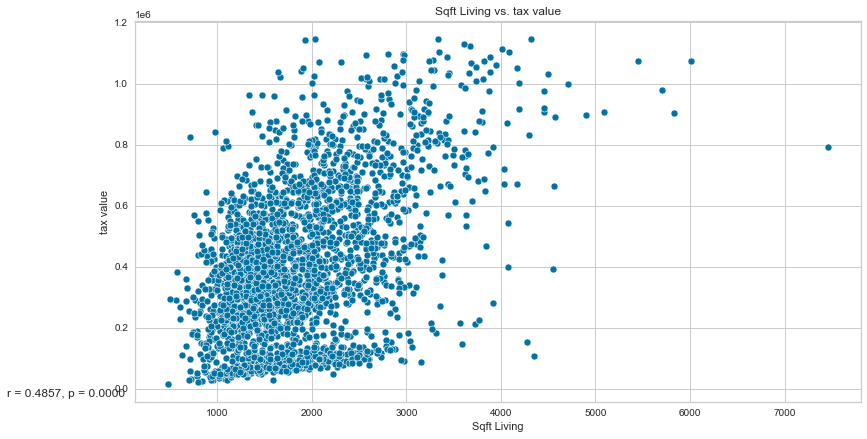

In [290]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(test_iqr.sqft_living, test_iqr.taxvalue)

sns.scatterplot(data=test_iqr, x=test_iqr.sqft_living, y=test_iqr.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 120, text, va='top', ha='right')

In [38]:
train_and_validate, test = train_test_split(eda, random_state=123, test_size=.2)
train, validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [39]:
def corrstatsgraphs3(df):
    """
    Description
    ----
    Outputs the general statistical description of the dataframe,
    outputs the correlation heatmap with target label, and outputs a distribution plot.
    
    Parameters
    ----
    df(DataFrame):
        The dataframe for which information will be displayed.
        
    Returns
    ----
    useful stats, correlation, and subplots
    
    """
       
    # Heatmap with min -1 to max 1 to all variables
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    corr = df.corr()
    plt.subplots(figsize=(22, 17))
    plt.title("Heatmap", fontsize = 'x-large')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 21, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, vmin=-1, vmax=1
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr 
    plt.figure(figsize=(10, 8)) 
    plt.title("Heatmap", fontsize = 'x-large')
    sns.heatmap(df.corr()[['taxvalue']].sort_values(by='taxvalue', 
    ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG'
    )
    sns.pairplot(df[['bedrooms', 'bathrooms', 'sqft_living', 'num_pools',
       'pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces',
       'garage_cars', 'ac_type', 'heating_type', 'year_built', 'sqft_lot',
       'lat', 'long', 'countyid', 'zip', 'fips', 'taxvalue']], corner=True, kind='reg', plot_kws={'line_kws':{'color':'red'}}
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr
    plt.figure(figsize=(16,10))
    df.corr()['taxvalue'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5), cmap='BrBG'
    )
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='reg', height=5, line_kws={'color': 'red'}
    )
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'}
    )
      
    sns.jointplot(x="bathrooms", y="taxvalue", data=df, ratio=5, kind='reg', height=5, line_kws={'color': 'red'}
    )
    sns.jointplot(x="bathrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'})

In [40]:
#corrstatsgraphs3(train)

In [41]:
train.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
1081,3.0,1.5,1289.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1962.0,6000.0,33811957.0,-118032469.0,1286.0,96185.0,6059.0,141623.0
610,3.0,2.0,1823.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1955.0,6600.0,33862309.0,-117948648.0,1286.0,97041.0,6059.0,432903.0
2069,3.0,2.0,1041.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1957.0,5860.0,33935264.0,-117924937.0,1286.0,96186.0,6059.0,371706.0
7016,3.0,3.5,3113.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,6.0,1976.0,15180.0,33769498.0,-117776822.0,1286.0,97005.0,6059.0,870258.0
4871,2.0,1.0,899.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1948.0,7048.0,33865021.0,-118006899.0,1286.0,96181.0,6059.0,45883.0


In [42]:
train.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
bedrooms,1.000000,0.566843,0.568140,0.231490,0.082292,0.081869,0.220747,0.285270,0.239887,-0.006035,-0.024637,0.252862,0.140750,0.096753,-0.075304,0.097077,-0.051227,0.097077,0.210934
bathrooms,0.566843,1.000000,0.830976,0.260383,0.107995,0.124030,0.375762,0.398626,0.407371,-0.009263,-0.000398,0.525095,0.245695,0.066809,-0.076395,0.130237,-0.026345,0.130237,0.491879
sqft_living,0.568140,0.830976,1.000000,0.329104,0.137957,0.160655,0.427590,0.431184,0.403581,-0.012311,-0.008689,0.491900,0.323822,0.068792,-0.076704,0.135547,-0.037724,0.135547,0.562445
num_pools,0.231490,0.260383,0.329104,1.000000,0.293753,0.178673,0.155949,0.165869,0.106501,-0.004459,0.070875,0.082793,0.161222,-0.039396,0.082937,-0.054078,-0.057543,-0.054078,0.174491
pool_w_spa_or_hottub,0.082292,0.107995,0.137957,0.293753,1.000000,0.757082,0.020729,0.061706,0.013063,0.016814,0.025057,0.040789,0.033592,-0.097383,0.106062,-0.105064,0.010000,-0.105064,0.123975
has_hottub_or_spa,0.081869,0.124030,0.160655,0.178673,0.757082,1.000000,0.014836,0.072105,0.039290,0.011113,0.025756,0.061732,0.019652,-0.138208,0.143488,-0.138775,0.011030,-0.138775,0.152419
fireplaces,0.220747,0.375762,0.427590,0.155949,0.020729,0.014836,1.000000,0.236307,0.186880,-0.005405,0.036066,0.357479,0.185086,0.338138,-0.361188,0.403971,-0.053068,0.403971,0.225645
garage_cars,0.285270,0.398626,0.431184,0.165869,0.061706,0.072105,0.236307,1.000000,0.121390,-0.007854,-0.008898,0.371415,0.209122,0.066180,-0.052846,0.089636,-0.012524,0.089636,0.201860
numberofstories,0.239887,0.407371,0.403581,0.106501,0.013063,0.039290,0.186880,0.121390,1.000000,-0.013229,0.016143,0.333062,0.002125,-0.027503,0.017758,0.011849,-0.015672,0.011849,0.165148
ac_type,-0.006035,-0.009263,-0.012311,-0.004459,0.016814,0.011113,-0.005405,-0.007854,-0.013229,1.000000,0.050641,-0.007320,0.000043,0.007611,0.001014,-0.000000,0.009287,0.000000,-0.012777


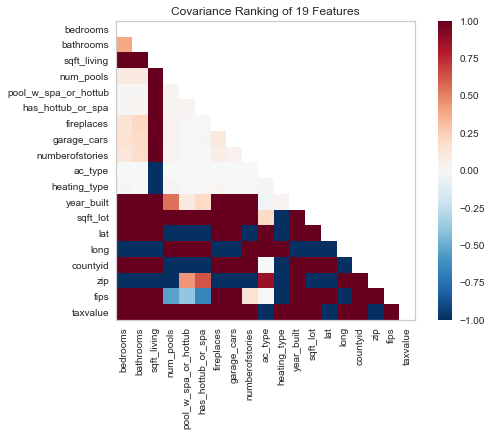

<AxesSubplot:title={'center':'Covariance Ranking of 19 Features'}>

In [43]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="covariance")
visualizer.fit_transform(train)
visualizer.show()

# What is the relationship between sqft living space vs tax value

Text(25, 120, 'r = 0.5624, p = 0.0000')

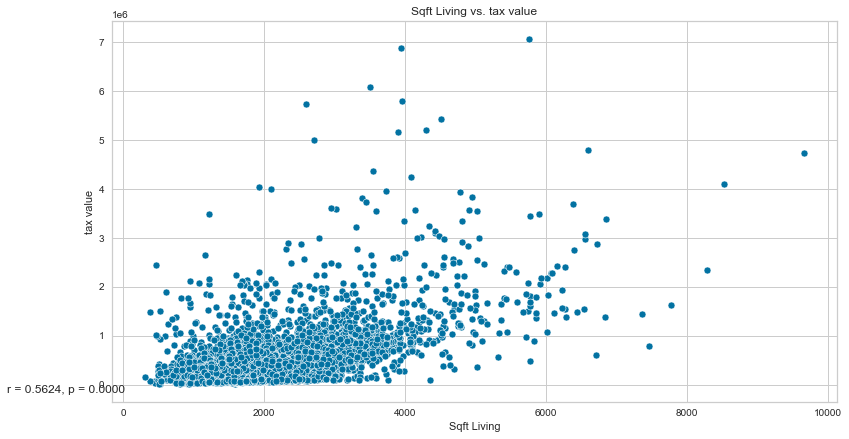

In [44]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(train.sqft_living, train.taxvalue)

sns.scatterplot(data=train, x=train.sqft_living, y=train.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 120, text, va='top', ha='right')

    Seems to be a strong relationship between sqft living space and tax value

# What is the relationship between number of bedrooms vs tax value?

Text(25, 50, 'r = 0.2109, p = 0.0000')

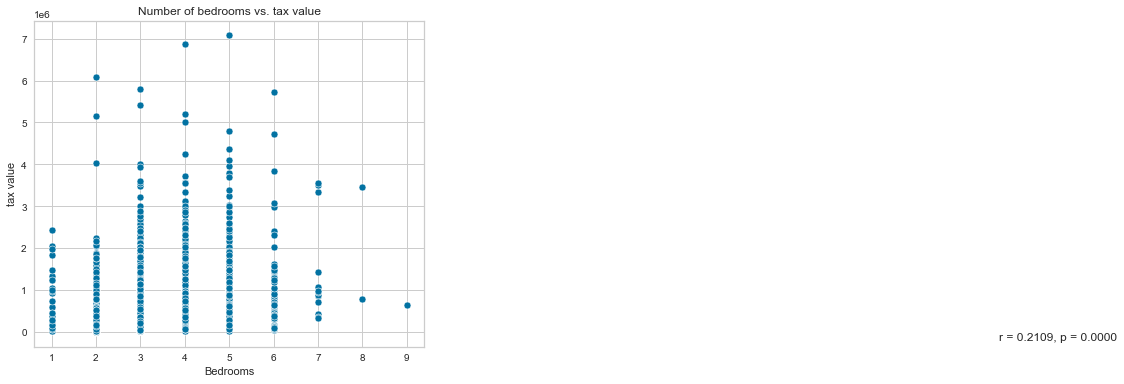

In [45]:
fig, axes = plt.subplots(figsize=(7, 6))

r, p = stats.pearsonr(train.bedrooms, train.taxvalue)

sns.scatterplot(data=train, x=train.bedrooms, y=train.taxvalue)
axes.set(
    xlabel='Bedrooms',
    ylabel='tax value',
    title='Number of bedrooms vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 50, text, va='top', ha='right')

    Seems to be a weak relationship between number of bedrooms and tax value

# What is the relationship between number of bathrooms vs tax value? 

Text(25, 50, 'r = 0.4919, p = 0.0000')

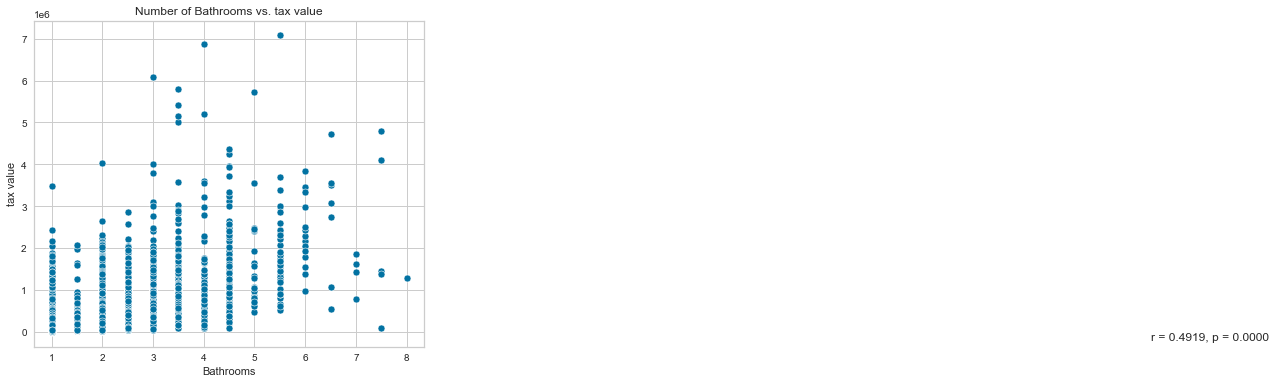

In [46]:
fig, axes = plt.subplots(figsize=(7, 6))

r, p = stats.pearsonr(train.bathrooms, train.taxvalue)

sns.scatterplot(data=train, x=train.bathrooms, y=train.taxvalue)
axes.set(
    xlabel='Bathrooms',
    ylabel='tax value',
    title='Number of Bathrooms vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 50, text, va='top', ha='right')

    Seems to be a relationship between number of bathrooms and tax value

# What is the relationship between pools with or without hot tubs and spas vs tax value?

r = 0.1745, p = 0.0000


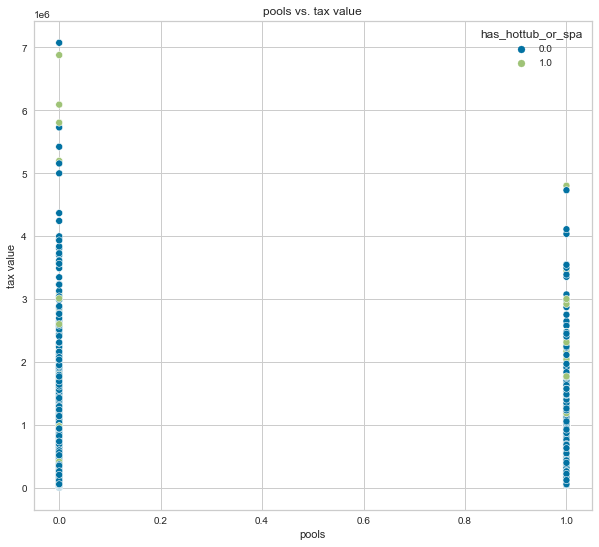

In [47]:
fig, axes = plt.subplots(figsize=(10, 9))

r, p = stats.pearsonr(train.num_pools, train.taxvalue)

sns.scatterplot(data=train, x=train.num_pools, y=train.taxvalue, hue=train.has_hottub_or_spa)
axes.set(
    xlabel='pools',
    ylabel='tax value',
    title='pools vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
print(text)


    preprocessing 

In [291]:
preprocessing = eda.copy(deep=True)

In [292]:
preprocessing_iqr = eda_iqr.copy(deep=True)

    Robust scaling remove outliers using IQR 75% and 25%

In [133]:
robust = eda.copy(deep=True)

In [134]:
robust = robust.drop(columns=['lat','long'])

In [135]:
robust.countyid = robust.countyid.astype('category')
robust.zip = robust.zip.astype('category')
robust.fips = robust.fips.astype('category')
robust.ac_type = robust.ac_type.astype('category')
robust.heating_type = robust.heating_type.astype('category')
robust.has_hottub_or_spa = robust.has_hottub_or_spa.astype('category')
robust.pool_w_spa_or_hottub = robust.pool_w_spa_or_hottub.astype('category')
robust.numberofstories = robust.numberofstories.astype('category')
robust.fireplaces = robust.fireplaces.astype('category')
robust.bedrooms = robust.bedrooms.astype('category')
robust.bathrooms = robust.bathrooms.astype('category')
robust.garage_cars = robust.garage_cars.astype('category')
robust.year_built = robust.year_built.astype('category')
robust.num_pools = robust.num_pools.astype('category')

In [102]:
robust.isnull().sum()

bedrooms                0
bathrooms               0
sqft_living             0
num_pools               0
pool_w_spa_or_hottub    0
has_hottub_or_spa       0
fireplaces              0
garage_cars             0
numberofstories         0
ac_type                 0
heating_type            0
year_built              0
sqft_lot                0
countyid                0
zip                     0
fips                    0
taxvalue                0
dtype: int64

    Drop columns that are not needed for the model and that have negivate correlation to target

In [52]:
preprocessing =  preprocessing.drop(columns=['lat', 'long'])

In [293]:
preprocessing_iqr =  preprocessing_iqr.drop(columns=['lat', 'long'])

In [53]:
preprocessing.countyid = preprocessing.countyid.astype('category')
preprocessing.zip = preprocessing.zip.astype('category')
preprocessing.fips = preprocessing.fips.astype('category')
preprocessing.ac_type = preprocessing.ac_type.astype('category')
preprocessing.heating_type = preprocessing.heating_type.astype('category')
preprocessing.has_hottub_or_spa = preprocessing.has_hottub_or_spa.astype('category')
preprocessing.pool_w_spa_or_hottub = preprocessing.pool_w_spa_or_hottub.astype('category')
preprocessing.numberofstories = preprocessing.numberofstories.astype('category')
preprocessing.fireplaces = preprocessing.fireplaces.astype('category')
preprocessing.bedrooms = preprocessing.bedrooms.astype('category')
preprocessing.bathrooms = preprocessing.bathrooms.astype('category')
preprocessing.garage_cars = preprocessing.garage_cars.astype('category')
preprocessing.year_built = preprocessing.year_built.astype('category')
preprocessing.num_pools = preprocessing.num_pools.astype('category')




In [294]:
preprocessing_iqr.countyid = preprocessing_iqr.countyid.astype('category')
preprocessing_iqr.zip = preprocessing_iqr.zip.astype('category')
preprocessing_iqr.fips = preprocessing_iqr.fips.astype('category')
preprocessing_iqr.ac_type = preprocessing_iqr.ac_type.astype('category')
preprocessing_iqr.heating_type = preprocessing_iqr.heating_type.astype('category')
preprocessing_iqr.has_hottub_or_spa = preprocessing_iqr.has_hottub_or_spa.astype('category')
preprocessing_iqr.pool_w_spa_or_hottub = preprocessing_iqr.pool_w_spa_or_hottub.astype('category')
preprocessing_iqr.numberofstories = preprocessing_iqr.numberofstories.astype('category')
preprocessing_iqr.fireplaces = preprocessing_iqr.fireplaces.astype('category')
preprocessing_iqr.bedrooms = preprocessing_iqr.bedrooms.astype('category')
preprocessing_iqr.bathrooms = preprocessing_iqr.bathrooms.astype('category')
preprocessing_iqr.garage_cars = preprocessing_iqr.garage_cars.astype('category')
preprocessing_iqr.year_built = preprocessing_iqr.year_built.astype('category')
preprocessing_iqr.num_pools = preprocessing_iqr.num_pools.astype('category')

In [295]:
train_and_validate, iqr_test = train_test_split(preprocessing_iqr, random_state=123, test_size=.2)
iqr_train, iqr_validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [296]:
dummy_train = pd.get_dummies(iqr_train[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_validate = pd.get_dummies(iqr_validate[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_test = pd.get_dummies(iqr_test[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
# merge dummies with orginal dataframe
iqr_train = pd.concat([iqr_train, dummy_train], axis=1)
iqr_validate = pd.concat([iqr_validate, dummy_validate], axis=1)
iqr_test = pd.concat([iqr_test, dummy_test], axis=1)
# drop columns with corresponding dummies
iqr_train = iqr_train.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip'])
iqr_validate = iqr_validate.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip'])
iqr_test = iqr_test.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip'])

In [297]:
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['sqft_living','sqft_lot']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [298]:
train_scaled_iqr, validate_scaled_iqr, test_scaled_iqr = scale_data(iqr_train, iqr_validate, iqr_test, return_scaler=False)

In [299]:
def iqr_X_y(bs_train, bs_validate, bs_test):

    # drop target data for X_train and assign target data for y_train
    X_train = bs_train.drop(columns=['taxvalue'])
    y_train = bs_train.taxvalue
    # drop target data for X_validate and assign target data for y_validate
    X_validate = bs_validate.drop(columns=['taxvalue'])
    y_validate = bs_validate.taxvalue
    # drop target data for X_test and assign target data for y_test 
    X_test = bs_test.drop(columns=['taxvalue'])
    y_test = bs_test.taxvalue
    
        
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [300]:
X_train_iqr, y_train_iqr, X_validate_iqr, y_validate_iqr, X_test_iqr, y_test_iqr = iqr_X_y(train_scaled_iqr, validate_scaled_iqr, test_scaled_iqr)

In [301]:
predictions_scale_iqr = pd.DataFrame({'actual': validate_scaled_iqr.taxvalue})

In [302]:
predictions_scale_iqr.head()

,actual
4345,735000.0
8442,370802.0
6575,661587.0
3903,77450.0
8195,77348.0


In [306]:
pd.concat([
    predictions_scale_iqr.apply(lambda col: r2_score(predictions_scale_iqr.actual, col)).rename('r2'),
    predictions_scale_iqr.apply(lambda col: mean_squared_error(predictions_scale_iqr.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
Ridge,0.319063,4.033118e+10,200826.251648


In [305]:
model = Ridge()
model.fit(X_train_iqr, y_train_iqr)
predictions_scale_iqr['Ridge'] = model.predict(X_validate_iqr)
model.score(X_train_iqr, y_train_iqr)

0.3672856298863658

In [54]:
preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14469 entries, 0 to 14472
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bedrooms              14469 non-null  category
 1   bathrooms             14469 non-null  category
 2   sqft_living           14469 non-null  float64 
 3   num_pools             14469 non-null  category
 4   pool_w_spa_or_hottub  14469 non-null  category
 5   has_hottub_or_spa     14469 non-null  category
 6   fireplaces            14469 non-null  category
 7   garage_cars           14469 non-null  category
 8   numberofstories       14469 non-null  category
 9   ac_type               14469 non-null  category
 10  heating_type          14469 non-null  category
 11  year_built            14469 non-null  category
 12  sqft_lot              14469 non-null  float64 
 13  countyid              14469 non-null  category
 14  zip                   14469 non-null  category
 15  fi

    baseline 

In [55]:
baseline = eda.copy(deep=True)

In [56]:
baseline =  baseline.drop(columns=['lat', 'long'])

In [57]:
baseline.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'num_pools',
       'pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces',
       'garage_cars', 'numberofstories', 'ac_type', 'heating_type',
       'year_built', 'sqft_lot', 'countyid', 'zip', 'fips', 'taxvalue'],
      dtype='object')

In [58]:
baseline.countyid = baseline.countyid.astype('category')
baseline.zip = baseline.zip.astype('category')
baseline.fips = baseline.fips.astype('category')
baseline.ac_type = baseline.ac_type.astype('category')
baseline.heating_type = baseline.heating_type.astype('category')
baseline.has_hottub_or_spa = baseline.has_hottub_or_spa.astype('category')
baseline.pool_w_spa_or_hottub = baseline.pool_w_spa_or_hottub.astype('category')
baseline.numberofstories = baseline.numberofstories.astype('category')


In [59]:
train_and_validate, bs_test = train_test_split(baseline, random_state=123, test_size=.2)
bs_train, bs_validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [60]:
dummy_train = pd.get_dummies(bs_train[['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories']], drop_first=[True])
dummy_validate = pd.get_dummies(bs_validate[['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories']], drop_first=[True])
dummy_test = pd.get_dummies(bs_test[['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories']], drop_first=[True])
# merge dummies with orginal dataframe
bs_train = pd.concat([bs_train, dummy_train], axis=1)
bs_validate = pd.concat([bs_validate, dummy_validate], axis=1)
bs_test = pd.concat([bs_test, dummy_test], axis=1)
# drop columns with corresponding dummies
bs_train = bs_train.drop(columns=['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories'])
bs_validate = bs_validate.drop(columns=['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories'])
bs_test = bs_test.drop(columns=['countyid', 'zip', 'fips', 'ac_type', 'heating_type', 'has_hottub_or_spa', 'numberofstories'])

In [61]:
def bs_X_y(bs_train, bs_validate, bs_test):

    # drop target data for X_train and assign target data for y_train
    X_train = bs_train.drop(columns=['taxvalue'])
    y_train = bs_train.taxvalue
    # drop target data for X_validate and assign target data for y_validate
    X_validate = bs_validate.drop(columns=['taxvalue'])
    y_validate = bs_validate.taxvalue
    # drop target data for X_test and assign target data for y_test 
    X_test = bs_test.drop(columns=['taxvalue'])
    y_test = bs_test.taxvalue
    
        
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [62]:
X_train, y_train, X_validate, y_validate, X_test, y_test = bs_X_y(bs_train, bs_validate, bs_test)

    Baseline w/ no feature selection, scaling, and outliers removal

In [63]:
predictions = pd.DataFrame({'actual': validate.taxvalue})

In [64]:
predictions_scale = pd.DataFrame({'actual': validate.taxvalue})

    baseline based on median of target (taxvalue)

In [65]:
predictions['baseline'] = train.taxvalue.median()

    make simple model LinearRegression

In [66]:
X_train_sm = train[['sqft_living']]
X_validate_sm  = validate[['sqft_living']]
y_train_sm = train.taxvalue



lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=4)
lm.fit(X_train_sm, y_train_sm)
predictions['simple_lm'] = lm.predict(X_validate_sm)
lm.score(X_train_sm, y_train_sm)

0.316344184915749

In [67]:
predictions.head()

,actual,baseline,simple_lm
6146,973890.0,410190.0,1.272427e+06
11722,167725.0,410190.0,2.911690e+05
13643,317147.0,410190.0,4.438989e+05
3338,601000.0,410190.0,3.094842e+05
13356,649760.0,410190.0,4.864273e+05


In [68]:
pd.concat([
    predictions.apply(lambda col: r2_score(predictions.actual, col)).rename('r2'),
    predictions.apply(lambda col: mean_squared_error(predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)



,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.028766,2.356057e+11,485392.291522
simple_lm,0.330437,1.533418e+11,391588.815125


In [69]:
m, b = lm.coef_[0], lm.intercept_
print(f'taxvalue = {m:.3f} x sqft_living + {b:.3f}')

taxvalue = 310.427 x sqft_living + -108970.737


    Linear Regression model/all features 

In [70]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions['multiple regr'] = model.predict(X_validate)
model.score(X_train, y_train)

0.5042356661804344

    Linear Regression model/all features w/ scaled features

In [71]:
train_and_validate, scale_test = train_test_split(preprocessing, random_state=123, test_size=.2)
scale_train, scale_validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [72]:
preprocessing.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'num_pools',
       'pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces',
       'garage_cars', 'numberofstories', 'ac_type', 'heating_type',
       'year_built', 'sqft_lot', 'countyid', 'zip', 'fips', 'taxvalue'],
      dtype='object')

In [73]:
dummy_train = pd.get_dummies(scale_test[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_validate = pd.get_dummies(scale_validate[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories','heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_test = pd.get_dummies(scale_train[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
# merge dummies with orginal dataframe
scale_test = pd.concat([scale_test, dummy_train], axis=1)
scale_validate = pd.concat([scale_validate, dummy_validate], axis=1)
scale_train = pd.concat([scale_train, dummy_test], axis=1)
# drop columns with corresponding dummies
scale_test = scale_test.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips','zip'])
scale_validate = scale_validate.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips','zip'])
scale_train = scale_train.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip'])

In [74]:
scale_train.head()

,sqft_living,sqft_lot,taxvalue,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,...,zip_97101.0,zip_97104.0,zip_97106.0,zip_97107.0,zip_97108.0,zip_97109.0,zip_97113.0,zip_97116.0,zip_97118.0,zip_97119.0
1081,1289.0,6000.0,141623.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,1823.0,6600.0,432903.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2069,1041.0,5860.0,371706.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7016,3113.0,15180.0,870258.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4871,899.0,7048.0,45883.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['sqft_living','sqft_lot']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [76]:
train_scaled, validate_scaled, test_scaled = scale_data(scale_train, scale_validate, scale_test)

In [77]:
train_scaled.head()

,sqft_living,sqft_lot,taxvalue,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,...,zip_97101.0,zip_97104.0,zip_97106.0,zip_97107.0,zip_97108.0,zip_97109.0,zip_97113.0,zip_97116.0,zip_97118.0,zip_97119.0
1081,0.105662,0.006209,141623.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,0.162714,0.006884,432903.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2069,0.079167,0.006052,371706.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7016,0.300534,0.016535,870258.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4871,0.063996,0.007388,45883.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
s_X_train, s_y_train, s_X_validate, s_y_validate, s_X_test, s_y_test = bs_X_y(scale_train, scale_validate, scale_test)

In [79]:
predictions_scale.head()

,actual
6146,973890.0
11722,167725.0
13643,317147.0
3338,601000.0
13356,649760.0


In [80]:
model = LinearRegression()
model.fit(s_X_train, s_y_train)
predictions['scale_multiple_regr'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5466269560335841

In [81]:
model = DecisionTreeRegressor()
model.fit(s_X_train, s_y_train)
predictions['DecisionTree'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.99840196866034

In [82]:
model = ExtraTreesRegressor()
model.fit(s_X_train, s_y_train)
predictions['ExtraTree'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.99840196866034

In [83]:
model = SGDRegressor(shuffle=False)
model.fit(s_X_train, s_y_train)
predictions['SGDRegressor'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

-1.5482146624173844e+22

In [84]:
model = BayesianRidge()
model.fit(s_X_train, s_y_train)
predictions['BayesianRidge'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.3164583264926186

In [85]:
model = KNeighborsRegressor()
model.fit(s_X_train, s_y_train)
predictions['KNeighborsRegressor'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5129541263235631

In [86]:
model = Ridge()
model.fit(s_X_train, s_y_train)
predictions['Ridge'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5446960790068136

In [87]:
medal = SVR()
model.fit(s_X_train, s_y_train)
predictions['SVR'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5446960790068136

In [88]:
model = NuSVR()
model.fit(s_X_train, s_y_train)
predictions['NuSVR'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

KeyboardInterrupt: 

In [ ]:
model = Lasso(alpha = 3, fit_intercept=True, max_iter= 10000, positive= True, selection='random', warm_start= False)
model.fit(s_X_train, s_y_train)
predictions['Lasso'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5668785222623228

In [ ]:
model = RidgeCV(scoring='neg_mean_squared_error')
model.fit(s_X_train, s_y_train)
predictions['RidgeCV'] = model.predict(s_X_validate)
model.score(s_X_train, s_y_train)

0.5324587757055382

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# # parameters to build the model on
mlp_parameters = {
    'alpha': [1, 2, 3],
    'fit_intercept': ['True', 'False'],
    'max_iter': [10000],
    'warm_start': ['True', 'False'],
    'positive': ['True', 'False'],
    'selection': ['cyclic', 'random']


}

# # instantiate the model
mlp = Lasso()

# # fit tree on training data
mlp = GridSearchCV(mlp, mlp_parameters,
                n_jobs=-1, cv=n_folds, 
                scoring='neg_mean_squared_error')
mlp.fit(s_X_train, s_y_train)

In [ ]:
print('Best parameters found:\n', mlp.best_params_)

Best parameters found:
 {'alpha': 3, 'fit_intercept': 'True', 'max_iter': 10000, 'positive': 'True', 'selection': 'random', 'warm_start': 'False'}


In [ ]:
scores_activation = mlp.cv_results_
pd.DataFrame(scores_activation).sort_values(["rank_test_score"], ascending=True).head(5)

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# # parameters to build the model on
mlp_parameters = {
    'fit_intercept': ['True', 'False'],
    'n_jobs': [-1],
    'positive': ['True', 'False'],


}

# # instantiate the model
mlp = LinearRegression()

# # fit tree on training data
mlp = GridSearchCV(mlp, mlp_parameters,
                n_jobs=-1, cv=n_folds, 
                scoring='neg_mean_squared_error')
mlp.fit(s_X_train, s_y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'], 'n_jobs': [-1],
                         'positive': ['True', 'False']},
             scoring='neg_mean_squared_error')

In [ ]:
print('Best parameters found:\n', mlp.best_params_)

Best parameters found:
 {'fit_intercept': 'True', 'n_jobs': -1, 'positive': 'True'}


In [ ]:
scores_activation = mlp.cv_results_
pd.DataFrame(scores_activation).sort_values(["rank_test_score"], ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_n_jobs,param_positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.139715,0.068876,0.034779,0.061920,True,-1,True,"{'fit_intercept': 'True', 'n_jobs': -1, 'posit...",-1.169166e+11,-6.333067e+32,-1.155858e+11,-1.128892e+11,-9.920751e+10,-1.266613e+32,2.533227e+32,1
1,1.162227,0.053294,0.004441,0.002540,True,-1,False,"{'fit_intercept': 'True', 'n_jobs': -1, 'posit...",-1.169166e+11,-6.333067e+32,-1.155858e+11,-1.128892e+11,-9.920751e+10,-1.266613e+32,2.533227e+32,1
2,1.107087,0.018361,0.003120,0.001109,False,-1,True,"{'fit_intercept': 'False', 'n_jobs': -1, 'posi...",-1.169166e+11,-6.333067e+32,-1.155858e+11,-1.128892e+11,-9.920751e+10,-1.266613e+32,2.533227e+32,1
3,0.884592,0.103866,0.002251,0.000475,False,-1,False,"{'fit_intercept': 'False', 'n_jobs': -1, 'posi...",-1.169166e+11,-6.333067e+32,-1.155858e+11,-1.128892e+11,-9.920751e+10,-1.266613e+32,2.533227e+32,1


# Robust scaling models

    Models with robust scaling of continuous variables

In [136]:
robust.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,countyid,zip,fips,taxvalue
0,2.0,1.0,1465.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1967.0,12647.0,2061.0,97099.0,6111.0,464000.0
1,3.0,2.0,1243.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1962.0,8432.0,1286.0,97078.0,6059.0,564778.0
2,3.0,2.5,1340.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1980.0,1199.0,1286.0,97051.0,6059.0,319668.0
3,3.0,2.5,1371.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2004.0,3445.0,2061.0,97107.0,6111.0,198054.0
4,4.0,2.0,1677.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1981.0,5304.0,1286.0,96962.0,6059.0,528847.0


In [137]:
robust.shape

(14469, 17)

In [138]:
scaler = RobustScaler()
data = scaler.fit_transform(robust[['sqft_living','sqft_lot']])
robust[['sqft_living','sqft_lot']] = pd.DataFrame(data)


In [139]:
robust.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,countyid,zip,fips,taxvalue
0,2.0,1.0,-0.276483,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1967.0,2.052143,2061.0,97099.0,6111.0,464000.0
1,3.0,2.0,-0.511653,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1962.0,0.546786,1286.0,97078.0,6059.0,564778.0
2,3.0,2.5,-0.408898,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1980.0,-2.036429,1286.0,97051.0,6059.0,319668.0
3,3.0,2.5,-0.376059,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,2004.0,-1.234286,2061.0,97107.0,6111.0,198054.0
4,4.0,2.0,-0.051907,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1981.0,-0.570357,1286.0,96962.0,6059.0,528847.0


In [140]:
robust.isnull().sum()

bedrooms                0
bathrooms               0
sqft_living             4
num_pools               0
pool_w_spa_or_hottub    0
has_hottub_or_spa       0
fireplaces              0
garage_cars             0
numberofstories         0
ac_type                 0
heating_type            0
year_built              0
sqft_lot                4
countyid                0
zip                     0
fips                    0
taxvalue                0
dtype: int64

In [141]:
robust.dropna(inplace=True)

In [142]:
robust.isnull().sum()

bedrooms                0
bathrooms               0
sqft_living             0
num_pools               0
pool_w_spa_or_hottub    0
has_hottub_or_spa       0
fireplaces              0
garage_cars             0
numberofstories         0
ac_type                 0
heating_type            0
year_built              0
sqft_lot                0
countyid                0
zip                     0
fips                    0
taxvalue                0
dtype: int64

In [143]:
train_and_validate, robust_test = train_test_split(robust, random_state=123, test_size=.2)
robust_train, robust_validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [144]:
robust_train.head()

,bedrooms,bathrooms,sqft_living,num_pools,pool_w_spa_or_hottub,has_hottub_or_spa,fireplaces,garage_cars,numberofstories,ac_type,heating_type,year_built,sqft_lot,countyid,zip,fips,taxvalue
9437,2.0,2.5,0.163136,0.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0,1980.0,0.227857,1286.0,97047.0,6059.0,175342.0
2954,3.0,2.0,0.629237,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1959.0,1.133214,1286.0,96990.0,6059.0,62663.0
4451,4.0,3.0,0.051907,1.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,1998.0,-0.298571,2061.0,97089.0,6111.0,781000.0
1420,3.0,1.5,-0.236229,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1956.0,0.428214,1286.0,97003.0,6059.0,217471.0
7795,2.0,1.0,1.617585,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1953.0,13.559286,2061.0,97083.0,6111.0,493000.0


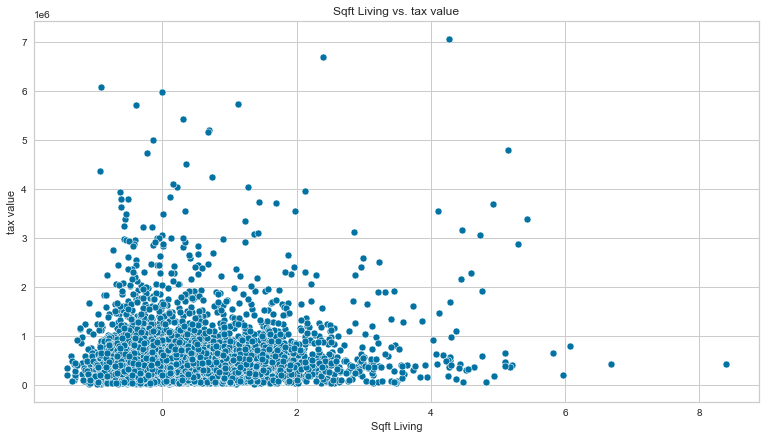

In [145]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(robust_train.sqft_living, robust_train.taxvalue)

sns.scatterplot(data=robust_train, x=robust_train.sqft_living, y=robust_train.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
#axes.text(25, 120, text, va='top', ha='right')

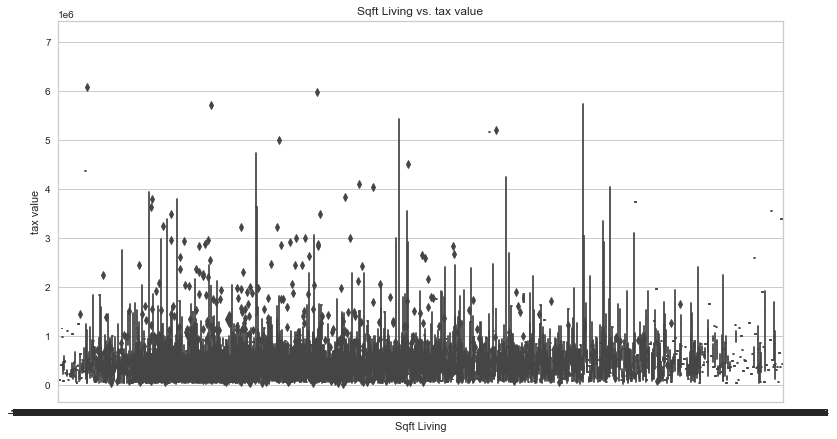

In [146]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(robust_train.sqft_living, robust_train.taxvalue)

sns.boxplot(data=robust_train, x=robust_train.sqft_living, y=robust_train.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'

In [113]:
dummy_train = pd.get_dummies(robust_test[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_validate = pd.get_dummies(robust_validate[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories','heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
dummy_test = pd.get_dummies(robust_train[['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip']], drop_first=[True])
# merge dummies with orginal dataframe
robust_test = pd.concat([robust_test, dummy_train], axis=1)
robust_validate = pd.concat([robust_validate, dummy_validate], axis=1)
robust_train = pd.concat([robust_train, dummy_test], axis=1)
# drop columns with corresponding dummies
robust_test = robust_test.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips','zip'])
robust_validate = robust_validate.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips','zip'])
robust_train = robust_train.drop(columns=['bedrooms', 'bathrooms', 'num_pools','pool_w_spa_or_hottub', 'has_hottub_or_spa', 'fireplaces','garage_cars', 'numberofstories', 'heating_type',
    'ac_type','year_built','countyid', 'fips', 'zip'])

In [121]:
def minmax_scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    '''
    columns_to_scale = ['sqft_living','sqft_lot']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[columns_to_scale])
    
    train_scaled[columns_to_scale] = scaler.transform(train[columns_to_scale])
    validate_scaled[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test_scaled[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [122]:
robust_train, robust_validate, robust_test = minmax_scale_data(robust_train, robust_validate, robust_test, return_scaler=False)

In [127]:
robust_train.head()

,sqft_living,sqft_lot,taxvalue,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bedrooms_7.0,bedrooms_8.0,...,zip_97101.0,zip_97104.0,zip_97106.0,zip_97107.0,zip_97108.0,zip_97109.0,zip_97113.0,zip_97116.0,zip_97118.0,zip_97119.0
9437,0.161638,0.007940,175342.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2954,0.209052,0.010792,62663.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4451,0.150323,0.006282,781000.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1420,0.121013,0.008571,217471.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7795,0.309591,0.049928,493000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


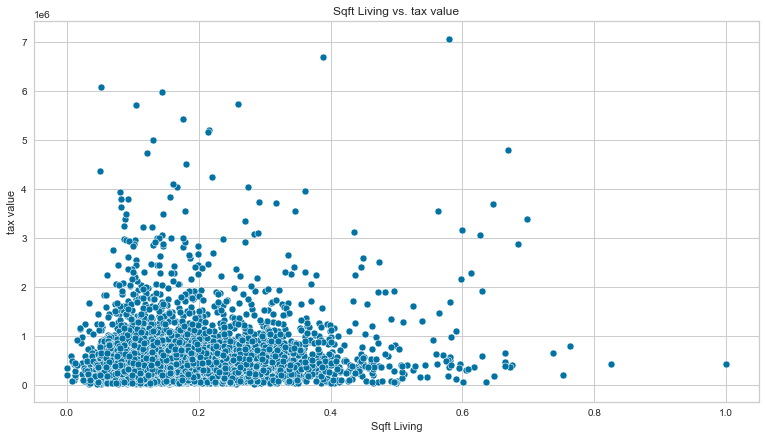

In [128]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(robust_train.sqft_living, robust_train.taxvalue)

sns.scatterplot(data=robust_train, x=robust_train.sqft_living, y=robust_train.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
#axes.text(25, 120, text, va='top', ha='right')

In [129]:
rs_X_train, rs_y_train, rs_X_validate,rs_y_validate, rs_X_test, rs_y_test = bs_X_y(robust_train, robust_validate, robust_test)

In [116]:
predictions_robust_scale = pd.DataFrame({'actual': robust_validate.taxvalue})

In [131]:
pd.concat([
    predictions_robust_scale.apply(lambda col: r2_score(predictions_robust_scale.actual, col)).rename('r2'),
    predictions_robust_scale.apply(lambda col: mean_squared_error(predictions_robust_scale.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
Ridge,0.455253,1.027009e+11,320469.810538


In [130]:
model = Ridge()
model.fit(rs_X_train, rs_y_train)
predictions_robust_scale['Ridge'] = model.predict(rs_X_validate)
model.score(rs_X_train, rs_y_train)

0.5453775249126347

In [ ]:
LinearRegression(), SGDRegressor(), BayesianRidge(), Lasso(), Ridge(), ElasticNet(), SVR(), KNeighborsRegressor(), ExtraTreesRegressor()

# create pipeline
estimators = []
estimators.append(('Scaler', MinMaxScaler()))
estimators.append(('LR', LinearRegression()))
model = Pipeline(estimators)
# create make_pipeline
make_model = make_pipeline(MinMaxScaler(),
                           LinearRegression())

# evaluate pipeline
seed = 123
scoring = make_scorer(r2_score)
results = cross_val_score(model, X_train, y_train, scoring=scoring)
print(results.mean())
# evaluate make_pipeline
make_results = cross_val_score(make_model, X_train, y_train, scoring=scoring)
print(make_results.mean())

# fit and predict on pipeline
model.fit(X_train, y_train)
mean_squared_error(model.predict(X_test), y_test)

-1.8435006692956205e+21
-1.8435006692956205e+21


1.4566240752920257e+34